In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [2]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

In [12]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [4]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [5]:
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

In [6]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [7]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
1,0.499975001249937,0.249993750156246,0.249993750156246,0.166663888935184,0.249996875039062,0.249996875039062,1.0,1.0,0.0,8.0,...,-83.8411549329758,-23.4946377202868,-46.5268726348877,77.395207285881,-16.6814198493958,-30.7433908134699,-3.76952870190144,79.014266461134,55.0725523233414,40.9605972766876
2,0.799984000319994,0.666655555740738,0.799984000319994,0.666655555740738,0.799992000079999,0.666661111157407,0.0,0.0,2.0,11.0,...,67.0121284723282,8.21379399299622,-47.4010380506516,2.19661918282509,-12.7164545357227,11.7041918039322,9.06723523139954,53.7836891412735,-29.5561633110046,46.020254611969
3,0.66664444518516,0.66664444518516,0.499975001249937,0.199996000079998,0.599988000239995,0.374995312558593,1.0,0.0,3.0,6.5,...,-47.3936591148376,5.8215354681015,13.7355995178223,29.1620630025864,30.9309476613998,-18.1216067373753,26.5127217769623,37.5479192733765,58.0591797828674,16.9279403686523
4,0.833319444675922,0.555549382784636,0.999966667777741,0.374995312558593,0.888879012455417,0.444441975322359,0.0,0.0,9.0,13.5,...,66.8304300308228,-15.1273374259472,-27.233210682869,95.7210485637188,-90.3887513875961,-119.001389503479,24.026518702507,201.532850056887,88.5585357546806,140.697974860668
5,0.499987500312492,0.399992000159997,0.399992000159997,0.399992000159997,0.444439506227709,0.39999600004,0.0,1.0,1.0,9.5,...,-57.1370173096657,19.8913884162903,3.86730098724365,40.0582662820816,-75.705543756485,5.51610147953034,25.6949986070395,8.34404516220093,99.5634136199951,60.4960389435291


<h2> 4.2 Converting strings to numerics </h2>

In [8]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y

In [2]:
df_nlp = pd.read_csv("nlp_features_train.csv", encoding = "latin-1") 
df_nlp = df_nlp.fillna('')
df_nlp.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [3]:
df_feat = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding = "latin-1")
df_feat = df_feat.fillna('')
df_feat.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [4]:
df_total = pd.merge(df_nlp, df_feat, on = "id")
df_total.head(2)

,id,qid1_x,qid2_x,question1_x,question2_x,is_duplicate_x,cwc_min,cwc_max,csc_min,csc_max,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [5]:
Y = df_total["is_duplicate_x"]
X= df_total.drop("is_duplicate_x", axis = 1)

<h2> 4.3 Random train test split( 70:30) </h2>

In [6]:
X_train,X_test, y_train, y_test = train_test_split(X,Y, stratify=Y, test_size=0.3)

In [7]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003, 36)
Number of data points in test data : (121287, 36)


In [8]:
X_train.columns

Index(['id', 'qid1_x', 'qid2_x', 'question1_x', 'question2_x', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'longest_substr_ratio', 'qid1_y', 'qid2_y', 'question1_y',
       'question2_y', 'is_duplicate_y', 'freq_qid1', 'freq_qid2', 'q1len',
       'q2len', 'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total',
       'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

In [9]:
questions = np.array(X_train['question1_x'].astype("unicode")) + np.array(X_train['question2_x'].astype("unicode"))

vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,2))
vectorizer.fit(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
vectorizer.idf_
vectorizer.get_feature_names()

['00',
 '000',
 '00k',
 '01',
 '02',
 '04',
 '04 lts',
 '06',
 '09',
 '10',
 '10 10',
 '10 11',
 '10 12',
 '10 15',
 '10 20',
 '10 am',
 '10 and',
 '10 best',
 '10 bollywood',
 '10 books',
 '10 can',
 '10 cbse',
 '10 cgpa',
 '10 class',
 '10 day',
 '10 days',
 '10 favorite',
 '10 favourite',
 '10 for',
 '10 greatest',
 '10 heads',
 '10 hollywood',
 '10 hours',
 '10 how',
 '10 if',
 '10 in',
 '10 is',
 '10 kg',
 '10 kgs',
 '10 kilos',
 '10 lakh',
 '10 lakhs',
 '10 list',
 '10 million',
 '10 minutes',
 '10 months',
 '10 most',
 '10 movies',
 '10 of',
 '10 on',
 '10 or',
 '10 pc',
 '10 percent',
 '10 places',
 '10 pounds',
 '10 seconds',
 '10 should',
 '10 things',
 '10 times',
 '10 to',
 '10 update',
 '10 websites',
 '10 what',
 '10 which',
 '10 why',
 '10 will',
 '10 with',
 '10 without',
 '10 year',
 '10 years',
 '10 yrs',
 '100',
 '100 and',
 '100 billion',
 '100 days',
 '100 dollar',
 '100 how',
 '100 in',
 '100 is',
 '100 million',
 '100 percent',
 '100 rupee',
 '100 shares',
 '100 

In [12]:
pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz --no-deps

    100% |████████████████████████████████| 12.0MB 116kB/s eta 0:00:011
  Running setup.py bdist_wheel for en-core-web-sm ... done
  Stored in directory: /home/shanud6711/.cache/pip/wheels/6a/47/fb/6b5a0b8906d8e8779246c67d4658fd8a544d4a03a75520197a
Successfully built en-core-web-sm
Note: you may need to restart the kernel to use updated packages.


In [10]:
import spacy
from tqdm import tqdm
import en_core_web_sm
# compute average word2vec for each review.
def avg_w2v_vectors(preprocessed_questions):
    nlp = en_core_web_sm.load()

    vecs1 = []
    # https://github.com/noamraph/tqdm
    # tqdm is used to print the progress bar
    for qu1 in tqdm(list(preprocessed_questions)):
        doc1 = nlp(qu1) 
        
        
        # 384 is the number of dimensions of vectors 
        mean_vec1 = np.zeros([len(doc1),96])
        for word1 in doc1:
            # word2vec
            vec1 = word1.vector
            # fetch df score
            try:
                idf = word2tfidf[str(word1)]
            except:
                idf = 0
            # compute final vec
            mean_vec1 += vec1 * idf
        mean_vec1 = mean_vec1.mean(axis=0)
        vecs1.append(mean_vec1)
    return vecs1

In [11]:
X_train_question1_w2v=avg_w2v_vectors(X_train['question1_x'])
X_test_question1_w2v=avg_w2v_vectors(X_test['question1_x'])

X_train_question2_w2v=avg_w2v_vectors(X_train['question2_x'])
X_test_question2_w2v=avg_w2v_vectors(X_test['question2_x'])

100%|██████████| 121287/121287 [20:55<00:00, 96.61it/s] 


In [12]:
train_feats_w2v = X_train.drop(["id", "is_duplicate_y", "qid1_x", "qid2_x", "qid1_y", "qid2_y", "question1_y", "question2_y", "question1_x", "question2_x"], axis = 1)
train_feats_w2v.shape

(283003, 26)

In [13]:
test_feats_w2v = X_test.drop(["id", "is_duplicate_y", "qid1_x", "qid2_x", "qid1_y", "qid2_y", "question1_y", "question2_y", "question1_x", "question2_x"], axis = 1)
test_feats_w2v.shape

(121287, 26)

In [14]:
from scipy.sparse import hstack

X_train_w2v = hstack([train_feats_w2v,X_train_question1_w2v,X_train_question2_w2v],format = "csr")
X_test_w2v = hstack([test_feats_w2v,X_test_question1_w2v,X_test_question2_w2v],format = "csr")


In [15]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in test data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


In [16]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8872038095555621


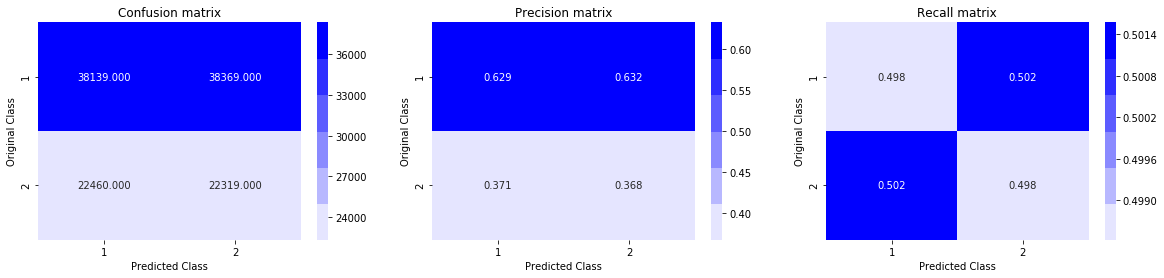

In [50]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

In [18]:
X_train_w2v=pd.SparseDataFrame(X_train_w2v).fillna(0)
X_test_w2v=pd.SparseDataFrame(X_test_w2v).fillna(0)

For values of alpha =  1e-05 The log loss is: 0.4525799176717347
For values of alpha =  0.0001 The log loss is: 0.4547417063157503
For values of alpha =  0.001 The log loss is: 0.4463228411402859
For values of alpha =  0.01 The log loss is: 0.43230362680216367
For values of alpha =  0.1 The log loss is: 0.44818391579502026
For values of alpha =  1 The log loss is: 0.47416026794108496
For values of alpha =  10 The log loss is: 0.5176170009417833


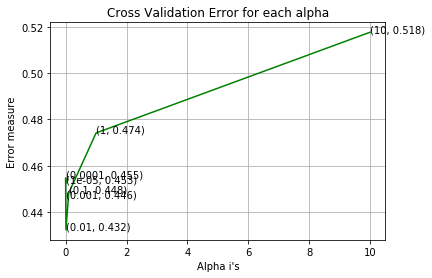

For values of best alpha =  0.01 The train log loss is: 0.4377011353634119
For values of best alpha =  0.01 The test log loss is: 0.43785816127243876
Total number of data points : 121287


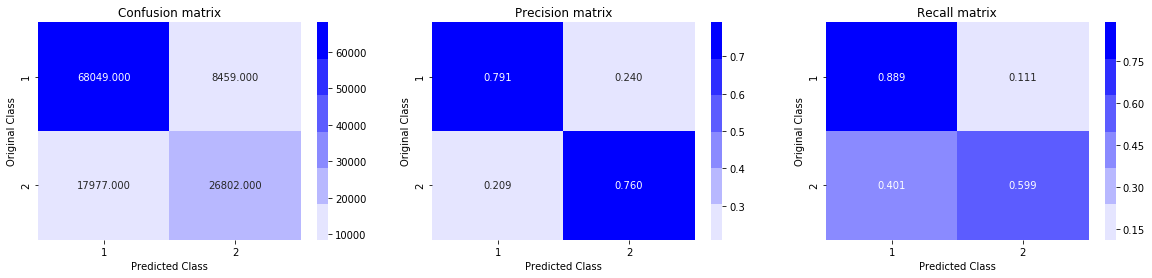

In [55]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42, n_jobs = -1,class_weight= "balanced")
    clf.fit(X_train_w2v,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_w2v, y_train)
    predict_y = sig_clf.predict_proba(X_test_w2v)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_w2v, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_w2v, y_train)

predict_y = sig_clf.predict_proba(X_train_w2v)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_w2v)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.501049951872035
For values of alpha =  0.0001 The log loss is: 0.6585278256347589
For values of alpha =  0.001 The log loss is: 0.5426775854305669
For values of alpha =  0.01 The log loss is: 0.4843166799186014
For values of alpha =  0.1 The log loss is: 0.6004019081854747
For values of alpha =  1 The log loss is: 0.6447654975374537
For values of alpha =  10 The log loss is: 0.6585278256347589


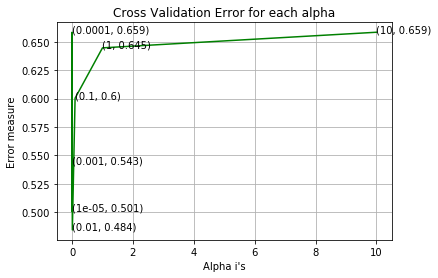

For values of best alpha =  0.01 The train log loss is: 0.4829428560579652
For values of best alpha =  0.01 The test log loss is: 0.4843166799186014
Total number of data points : 121287


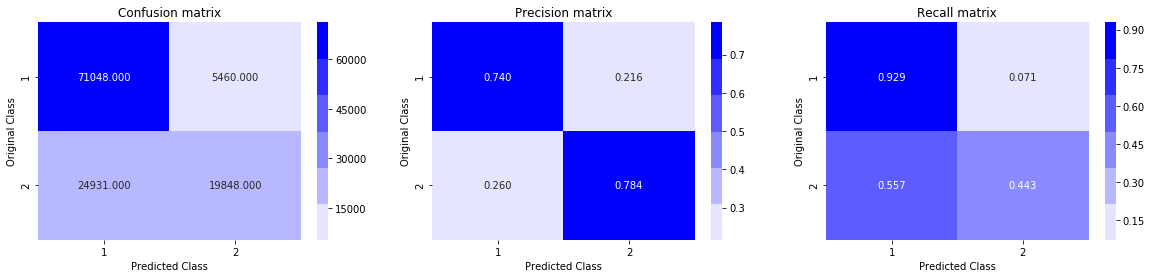

In [20]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42,n_jobs=-1)
    clf.fit(X_train_w2v, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_w2v, y_train)
    predict_y = sig_clf.predict_proba(X_test_w2v)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train_w2v, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_w2v, y_train)

predict_y = sig_clf.predict_proba(X_train_w2v)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_w2v)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [22]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

X_train_w2v=X_train_w2v.as_matrix()
X_test_w2v=X_test_w2v.as_matrix()
y_train=y_train.as_matrix()

d_train = xgb.DMatrix(X_train_w2v, label=y_train)
d_test = xgb.DMatrix(X_test_w2v, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train_w2v,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684853	valid-logloss:0.684882
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.61512	valid-logloss:0.615607
[20]	train-logloss:0.563673	valid-logloss:0.56465
[30]	train-logloss:0.525481	valid-logloss:0.526675
[40]	train-logloss:0.496	valid-logloss:0.497506
[50]	train-logloss:0.473293	valid-logloss:0.474938
[60]	train-logloss:0.455034	valid-logloss:0.456835
[70]	train-logloss:0.440303	valid-logloss:0.442201
[80]	train-logloss:0.428369	valid-logloss:0.430382
[90]	train-logloss:0.418752	valid-logloss:0.4208
[100]	train-logloss:0.410769	valid-logloss:0.412868
[110]	train-logloss:0.404189	valid-logloss:0.406332
[120]	train-logloss:0.398658	valid-logloss:0.400871
[130]	train-logloss:0.393979	valid-logloss:0.396199
[140]	train-logloss:0.390023	valid-logloss:0.392263
[150]	train-logloss:0.386659	valid-logloss:0.388961
[160]	train-logloss:0.383575	valid-

Total number of data points : 121287


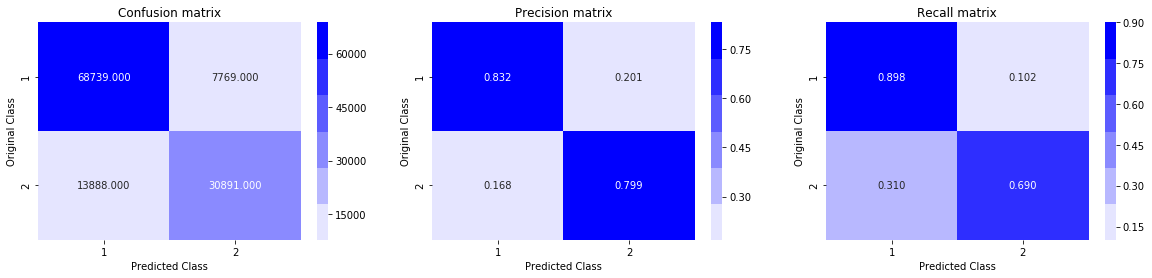

In [23]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h1> 5. Assignments </h1>

1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


,id,qid1_x,qid2_x,question1_x,question2_x,is_duplicate_x,cwc_min,cwc_max,csc_min,csc_max,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [5]:
Y_tfidf = df_total["is_duplicate_x"]
X_tfidf= df_total.drop("is_duplicate_x", axis = 1)

In [6]:
train_x_tfidf, test_x_tfidf , train_y, test_y = train_test_split(X_tfidf, Y_tfidf, test_size = 0.3, stratify = Y_tfidf)
print("Number of data points in train data :", train_x_tfidf.shape)
print("Number of data points in test data :", test_x_tfidf.shape)

Number of data points in train data : (283003, 36)
Number of data points in test data : (121287, 36)


In [7]:
train_x_tfidf.columns

Index(['id', 'qid1_x', 'qid2_x', 'question1_x', 'question2_x', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'longest_substr_ratio', 'qid1_y', 'qid2_y', 'question1_y',
       'question2_y', 'is_duplicate_y', 'freq_qid1', 'freq_qid2', 'q1len',
       'q2len', 'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total',
       'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

# train Features

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = np.array(train_x_tfidf['question1_x'].astype("unicode")) + np.array(train_x_tfidf['question2_x'].astype("unicode"))

tfidf = TfidfVectorizer(lowercase=False,ngram_range=(1,3),min_df=10)
tfidf.fit(questions)
tfidf_train =tfidf.transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [79]:
len(tfidf.get_feature_names())

122765

In [80]:
tfidf_train.shape

(283003, 122765)

# test features

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = np.array(test_x_tfidf['question1_x'].astype("unicode")) + np.array(test_x_tfidf['question2_x'].astype("unicode"))

#tfidf = TfidfVectorizer(lowercase=False)
tfidf_test=tfidf.transform(questions)

# dict key:word and value:tf-idf score
word2tfidf_test = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [82]:
len(tfidf.get_feature_names())

122765

In [83]:
tfidf_test.shape

(121287, 122765)

In [84]:
train_feats = train_x_tfidf.drop(["id", "is_duplicate_y", "qid1_x", "qid2_x", "qid1_y", "qid2_y", "question1_y", "question2_y", "question1_x", "question2_x"], axis = 1)
train_feats.shape

(283003, 26)

In [85]:
test_feats = test_x_tfidf.drop(["id", "is_duplicate_y", "qid1_x", "qid2_x", "qid1_y", "qid2_y", "question1_y", "question2_y", "question1_x", "question2_x"], axis = 1)
test_feats.shape

(121287, 26)

# making the  model

In [86]:
from scipy.sparse import hstack

X_train = hstack([train_feats,tfidf_train],format = "csr")


In [87]:
X_train.shape

(283003, 122791)

In [88]:
train_y.shape

(283003,)

In [89]:
X_test = hstack([test_feats,tfidf_test],format = "csr")

In [90]:
X_test.shape

(121287, 122791)

In [91]:
test_y.shape

(121287,)

# Logistic regression with tfidf vec

For values of alpha =  1e-05 The log loss is: 0.4051610001597163
For values of alpha =  0.0001 The log loss is: 0.4038326200076756
For values of alpha =  0.001 The log loss is: 0.4267966850661711
For values of alpha =  0.01 The log loss is: 0.4559996558368846
For values of alpha =  0.1 The log loss is: 0.4634252450815399
For values of alpha =  1 The log loss is: 0.49490282801765517
For values of alpha =  10 The log loss is: 0.5461463590609442


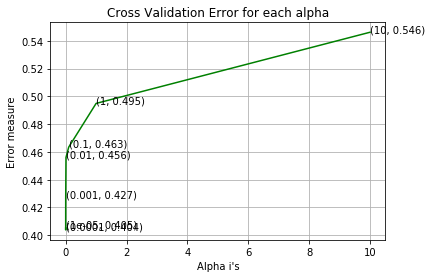

For values of best alpha =  0.0001 The train log loss is: 0.3911013998478218
For values of best alpha =  0.0001 The test log loss is: 0.3940003195746835
Total number of data points : 121287


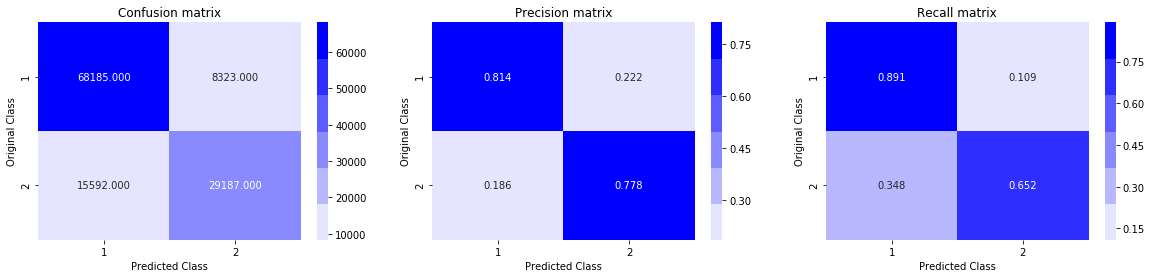

In [95]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_tfidf,train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_test, test_y)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train,train_y)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(test_y, predicted_y)

# linear SVM with tfidf

For values of alpha =  1e-05 The log loss is: 0.43282936463390015
For values of alpha =  0.0001 The log loss is: 0.43899659592973195
For values of alpha =  0.001 The log loss is: 0.4656200932810228
For values of alpha =  0.01 The log loss is: 0.4722079231878463
For values of alpha =  0.1 The log loss is: 0.48369348793307015
For values of alpha =  1 The log loss is: 0.5794922263519543
For values of alpha =  10 The log loss is: 0.6422913108070278


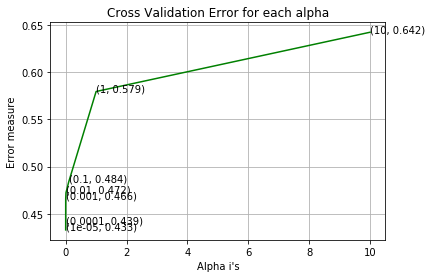

For values of best alpha =  1e-05 The train log loss is: 0.43003130493162606
For values of best alpha =  1e-05 The test log loss is: 0.43282936463390015
Total number of data points : 121287


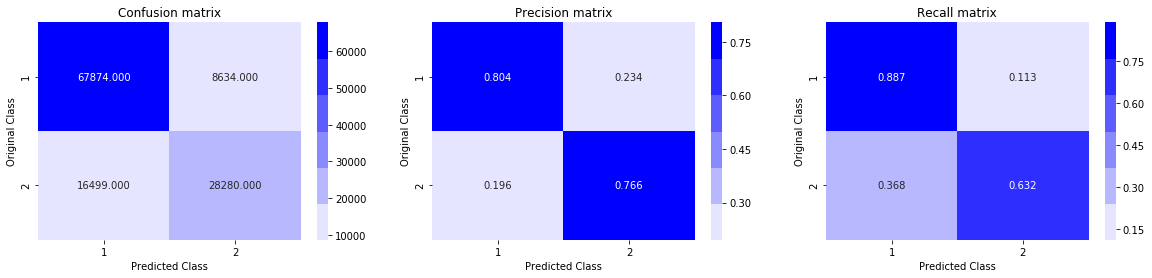

In [96]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train,train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train,train_y)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, train_y)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(test_y, predicted_y)

# Hyperparameter tunning using RandomSearch

In [19]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from tqdm import tqdm

param_grid = {"max_depth":[1,5,10,50,100,500,1000],
              "n_estimators":[50,100,150,200,300,400,500]}

xgb_model = RandomizedSearchCV(xgb.XGBClassifier(n_jobs=-1,random_state=25), param_distributions=param_grid,n_iter=20,scoring='neg_log_loss',cv=3,n_jobs=-1)
xgb_model.fit(X_train,y_train)
xgb_model.best_params_

{'max_depth': 5, 'n_estimators': 400}

Train log loss =  0.2295316629876758  Test log loss =  0.3351007574382394


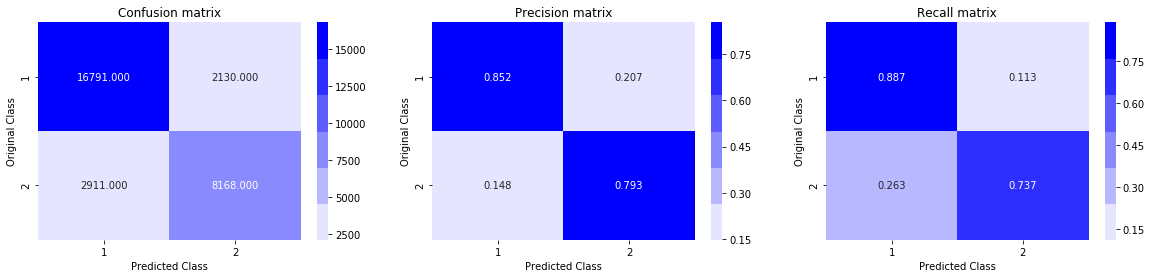

In [21]:
clf=xgb.XGBClassifier(n_jobs=-1,random_state=25,max_depth=5,n_estimators=400)
clf.fit(X_train,y_train)
y_pred_test=clf.predict_proba(X_test)
y_pred_train=clf.predict_proba(X_train)
log_loss_train = log_loss(y_train, y_pred_train, eps=1e-15)
log_loss_test=log_loss(y_test,y_pred_test,eps=1e-15)
print('Train log loss = ',log_loss_train,' Test log loss = ',log_loss_test)
predicted_y=np.argmax(y_pred_test,axis=1)
plot_confusion_matrix(y_test,predicted_y)

In [24]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Model","Feature Vectors","log loss"]
x.add_row(['Logistic regression','TFIDF w2v','0.437'])
x.add_row(['Linear SVM','TFIDF w2v','0.484'])
x.add_row(['XGBOOST','TFIDF w2v','0.357'])
x.add_row(['Logistic regression','TFIDF ','0.394'])
x.add_row(['Linear SVM','TFIDF','0.432'])
x.add_row(['XGBOOST','TFIDF w2v ','0.3351'])

print(x)

+---------------------+-----------------+----------+
|        Model        | Feature Vectors | log loss |
+---------------------+-----------------+----------+
| Logistic regression |    TFIDF w2v    |  0.437   |
|      Linear SVM     |    TFIDF w2v    |  0.484   |
|       XGBOOST       |    TFIDF w2v    |  0.357   |
| Logistic regression |      TFIDF      |  0.394   |
|      Linear SVM     |      TFIDF      |  0.432   |
|       XGBOOST       |    TFIDF w2v    |  0.3351  |
+---------------------+-----------------+----------+
